In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from Place import Sight, Hotel
from collections import namedtuple, defaultdict

In [2]:
interests = []
sights_list = []
sights_df = pd.read_json('sights.json')
for row in sights_df.itertuples():
    sights_list.append(Sight(row))

Location = namedtuple('Location', ['lat', 'lng'])
hotel = Hotel({'name': 'Dormy Inn Akihabara', 'location': Location(35.702540, 139.773290)})
hotel_list = [hotel]

In [3]:
def df_loc(place_list):
    df = pd.DataFrame(columns=['name', 'lat', 'lng'])
    for place in place_list:
        lat = float(place.location.lat)
        lng = float(place.location.lng)
        df = df.append(pd.Series({'name': place.name, 'lat': lat, 'lng': lng}), ignore_index=True)
    return df

sights_loc_df = df_loc(sights_list)
hotel_loc_df = df_loc(hotel_list)

In [4]:
df = sights_loc_df
offset = 0.01
print('\t\t{}\n{}\t\t\t{}\n\t\t{}'.format(df.lat.max() + offset, df.lng.min() - offset, \
                                          df.lng.max() + offset, df.lat.min() - offset))

bb = (df.lng.min() - offset, df.lng.max() + offset, \
      df.lat.min() - offset, df.lat.max() + offset)
print(bb)

		35.7431093
139.5604317			139.8207004
		35.609335900000005
(139.5604317, 139.8207004, 35.609335900000005, 35.7431093)


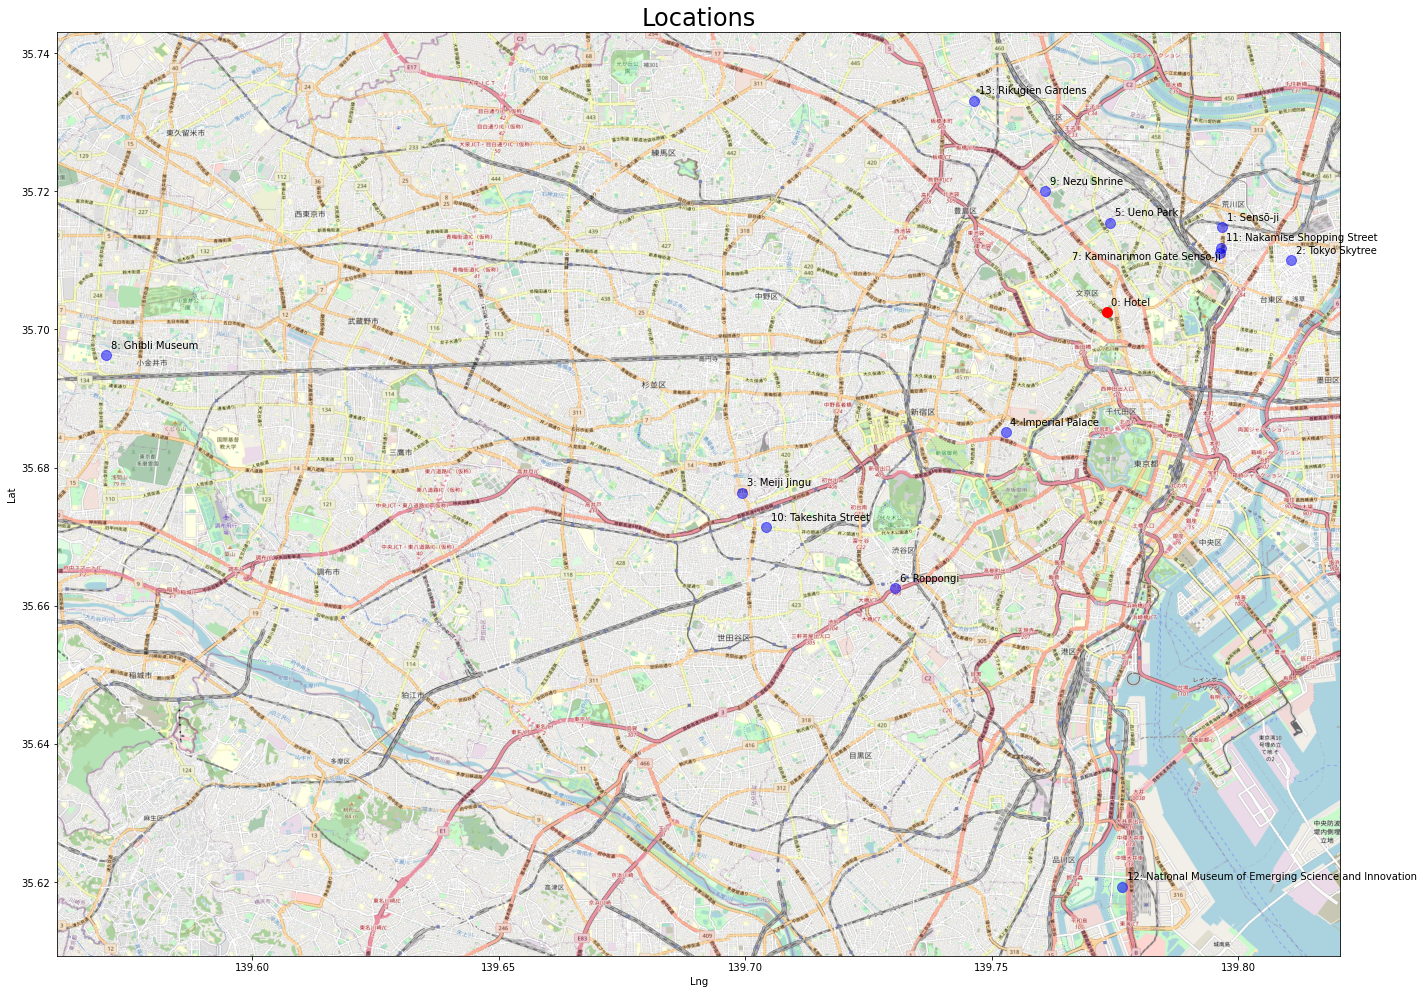

In [5]:
fig, ax = plt.subplots(figsize=(23,17))
tokyo_map = plt.imread('tokyo_map.png')
plt.scatter(hotel_loc_df.lng, hotel_loc_df.lat, zorder=2, alpha=1, c='r', s=100)
plt.scatter(sights_loc_df.lng, sights_loc_df.lat, zorder=1, alpha=0.5, c='b', s=100)
ax.annotate(s='{}: {}'.format(0, 'Hotel'), xy=(hotel_loc_df.lng, hotel_loc_df.lat), \
                    xytext=(hotel_loc_df.lng+0.001, hotel_loc_df.lat+0.001))
for point in sights_loc_df.itertuples():
    if point.Index == 6:
        ax.annotate(s='{}: {}'.format(point.Index+1, point.name), xy=(point.lng, point.lat), \
                xytext=(point.lng-0.03, point.lat-0.001))
    else:
        ax.annotate(s='{}: {}'.format(point.Index+1, point.name), xy=(point.lng, point.lat), \
                    xytext=(point.lng+0.001, point.lat+0.001))



ax.set_title('Locations', size=24)
ax.set_xlim(bb[0], bb[1])
ax.set_ylim(bb[2], bb[3])
ax.set_xlabel('Lng')
ax.set_ylabel('Lat')

ax.imshow(tokyo_map, zorder=0, extent=bb, aspect='auto')

plt.show()

In [6]:
from scipy.spatial.distance import cdist
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [27]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    total_time = 0
    for day in range(data['days']):
        index = routing.Start(day)
        plan_output = 'Route for day {}:\n'.format(day+1)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['cost'][node_index]
            previous_index = index

            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, day)
            
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                            solution.Min(time_var),
                                            solution.Max(time_var))
        plan_output += 'Load of the route: {}\n'.format(route_load)
        plan_output += 'Time of the route: {}min\n'.format(solution.Min(time_var))
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        total_time += solution.Min(time_var)
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total places visited: {}'.format(total_load))
    print('Total time of all routes: {}min'.format(total_time))

def haversine_distance(u,v):
    r = 6378.137
    [lat_u, lng_u] = u
    [lat_v, lng_v] = v
    lat_delta = lat_v - lat_u
    lng_delta = lng_v - lng_u
    a = (np.sin(np.radians(lat_delta/2))**2 + np.sin(np.radians(lng_delta/2))**2 * \
         np.cos(np.radians(lat_u)) * np.cos(np.radians(lat_v)))
    d = 2 * r * np.arcsin(np.sqrt(a))
    return d * 1000 #in metres


In [42]:
loc_df = hotel_loc_df.append(sights_loc_df).drop(['name'], axis=1).reset_index(drop=True)
d_matrix = cdist(loc_df, loc_df, haversine_distance)
data = {'distance_matrix': d_matrix, 'days': 3, 'hotel': 0}
data['cost'] = [0] + [1 for i in range(len(sights_loc_df.index))]
data['capacity'] = [5 for i in range(data['days'])]
data['time_windows'] = [(0,60)] + [(0, 480) for i in range(len(sights_loc_df.index))]
data['time_matrix'] = data['distance_matrix'] / 300
data['time_matrix_wst'] = []
for row in data['time_matrix']:
    data['time_matrix_wst'].append([time+90 if time != 0 else 0 for time in row])

In [43]:
# RoutingModel(distance_matrix, vehicles, depot). 
# "Depot" value is the index value of the depot in calculation of the distance matrix

#This creates a manager/routing object
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['days'], data['hotel'])
routing = pywrapcp.RoutingModel(manager)

#This creates a callback object and cost evaluator
def time_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


#capacity restriction
def cost_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return data['cost'][from_node]

cost_callback_index = routing.RegisterUnaryTransitCallback(cost_callback)
routing.AddDimensionWithVehicleCapacity(cost_callback_index, 0, data['capacity'], True, 'Capacity')

time = 'Time'
allowable_waiting_time = 60
max_time_per_day = 480
routing.AddDimension(transit_callback_index, allowable_waiting_time, max_time_per_day, False, time)
time_dimension = routing.GetDimensionOrDie(time)
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == 0:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    
#Add time window constraints
for day in range(data['days']):
    index = routing.Start(day)
    time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0], data['time_windows'][0][1])
    
#Instantiates route start and end times for each day
for i in range(data['days']):
    routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))
    
#this solves
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = routing.SolveWithParameters(search_parameters)

#print solution
if solution:
    print_solution(data, manager, routing, solution)

Route for day 1:
0 Time(0,0) -> 12 Time(30,30) -> 6 Time(51,51) -> 10 Time(59,59) -> 3 Time(61,61) -> 8 Time(100,100) -> 0 Time(100,100)
Load of the route: 5
Time of the route: 100min

Route for day 2:
0 Time(0,0) -> 11 Time(7,7) -> 1 Time(8,8) -> 2 Time(12,12) -> 7 Time(16,16) -> 0 Time(16,16)
Load of the route: 4
Time of the route: 16min

Route for day 3:
0 Time(0,0) -> 5 Time(4,4) -> 9 Time(8,8) -> 13 Time(14,14) -> 4 Time(31,31) -> 0 Time(31,31)
Load of the route: 4
Time of the route: 31min

Total distance of all routes: 223m
Total places visited: 13
Total time of all routes: 147min
